# **Step 2:** Make Predictions with a Previouly Trained <nobr>Micro$\mathbb{S}$plit</nobr> Model

# Objective
In this notebook, we will evaluate the performance of pre-trained MicroSplit model on the test dataset.
Qualitatively, we will look at both full frame predictions, and zoomed-in crops.
We will also inspect the sampling property: given a input, MicroSplit can generate multiple outputs by sampling from the posterior distribution.
This allows the end user to visually inspect the uncertainty in the predictions.

Finally, we will quantitatively evaluate the model using several metrics. 
A quick note on metrics: To address the intensity scale differences between low-SNR inputs and high-SNR groundtruth images in fluorescence microscopy, we used modified versions of PSNR, SSIM, and MS-SSIM that account for these variations:

Scale invariant variants of SSIM and MS-SSIM have been taken from [MicroSSIM: Improved Structural Similarity for Comparing Microscopy Data
](https://arxiv.org/abs/2408.08747). Scale invariant variant of PSNR has been taken from [Content-aware image restoration: pushing the limits of fluorescence microscopy
](https://www.nature.com/articles/s41592-018-0216-7).

#### General imports

In [1]:
import os
import copy
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.utils.utils import (
    plot_input_patches,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    plot_error,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

#### Experiments specific imports

In [2]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

## Selection of a sub-dataset 

In [3]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

class Channels:
    Nucleus = 0
    MicroTubules = 1
    NuclearMembrane = 2
    Centromere = 3

class ExposureDuration:
    VeryLow = "2ms"
    Low = "3ms"
    Medium = "5ms"
    High = "20ms"
    VeryHigh = "500ms"

allowed_exposure_durations = [ExposureDuration.VeryLow, ExposureDuration.Low, ExposureDuration.Medium, ExposureDuration.High, ExposureDuration.VeryHigh]

## Select the channels and exposure duration
<div class="alert alert-block alert-info">
<b> Task: </b>Set two entries from the following list for the channels.
0 - Nucleus, 1 - Microtubules, 2 - Centromere, 3 - Nuclear Membrane
An example would be [0, 1] for Nucleus and Microtubules.
</div>

In [4]:
TARGET_CHANNEL_IDX_LIST = [Channels.MicroTubules, Channels.Nucleus]

<div class="alert alert-block alert-info">
<b> Task: </b>Pick one entry from the following list for the exposure duration.
VeryLow, Low,Medium,High, VeryHigh
</div>

In [5]:
EXPOSURE_DURATION = ExposureDuration.Medium


In [6]:
TARGET_CHANNEL_IDX_LIST = sorted(TARGET_CHANNEL_IDX_LIST)
assert EXPOSURE_DURATION in allowed_exposure_durations, f"Exposure duration {EXPOSURE_DURATION} not in {allowed_exposure_durations}"
assert len(TARGET_CHANNEL_IDX_LIST) == 2, f"Only 2 target channels are allowed, got {len(TARGET_CHANNEL_IDX_LIST)}"

In [7]:
from notebook_utils import get_all_channel_list
CHANNEL_IDX_LIST = get_all_channel_list(TARGET_CHANNEL_IDX_LIST)

## Selection of MicroSplit network Weights
<div class="alert alert-block alert-info">
<b> Task: </b> We have two options. For some of the channel combinations, we have pre-trained models. If you want to evaluate the pre-trained model, set <b>evaluate_pretrained_model=True</b>. If you want to evaluate the model you trained with 01_training.ipynb, set <b>evaluate_recently_trained_model=True</b>.
Since one can only evaluate one model at a time, exactly one of the two variables must be True and the other must be False.
</div>

In [8]:
evaluate_pretrained_model = True
evaluate_recently_trained_model  =False
assert evaluate_pretrained_model != evaluate_recently_trained_model, "Please select only one option"

### Download the data

In [9]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data/",
    registry={f"ht_lif24_{EXPOSURE_DURATION}.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/noise_models/{EXPOSURE_DURATION}/",
    registry={
        f"noise_model_Ch{CHANNEL_IDX_LIST[0]}.npz": None,
        f"noise_model_Ch{CHANNEL_IDX_LIST[1]}.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path=f"./pretrained_checkpoints/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/ckpts/{EXPOSURE_DURATION}/",
    registry={f"best_{TARGET_CHANNEL_IDX_LIST[0]}_{TARGET_CHANNEL_IDX_LIST[1]}.ckpt": None},
)


In [10]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname)

for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip())

pretrained_model_available = False
for f in MODEL_CHECKPOINTS.registry:
    if MODEL_CHECKPOINTS.is_available(f):
        MODEL_CHECKPOINTS.fetch(f"{f}")
        pretrained_model_available = True

assert pretrained_model_available, "Pretrained model not available. First train the model using the 01_training.ipynb."

### Get configs

In [11]:
train_data_config, val_data_config, test_data_config = get_data_configs(
    dset_type=EXPOSURE_DURATION, channel_idx_list=CHANNEL_IDX_LIST,
)
experiment_params = get_microsplit_parameters(
    dset_type=EXPOSURE_DURATION, nm_path=NOISE_MODELS.path, channel_idx_list=CHANNEL_IDX_LIST
)

### Create dataset

In [12]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_lif24_{EXPOSURE_DURATION}.zip.unzip/{EXPOSURE_DURATION}",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=test_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set1/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set2/uSplit_5ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set3/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set4/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set5/uSplit_5ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set6/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: Fals

## Pick the evaluation dataset
<div class="alert alert-block alert-info">
<b> Task: </b> If you want to evaluate on the validation dataset. Set <b>evaluate_on_validation=True</b>. For evaluating the model on the test dataset, set <b>evaluate_on_validation=False</b>.

NOTE: For running 03_calibration.ipynb, you need to evaluate the model both on the validation dataset and test dataset.
</div>

In [13]:
evaluate_on_validation = False

In [14]:
if evaluate_on_validation:
    dset = val_dset
else:
    dset = test_dset

### Get experiment configs

In [15]:
experiment_params["data_stats"] = data_stats

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Visualize input data


[20216, 21157, 3281]

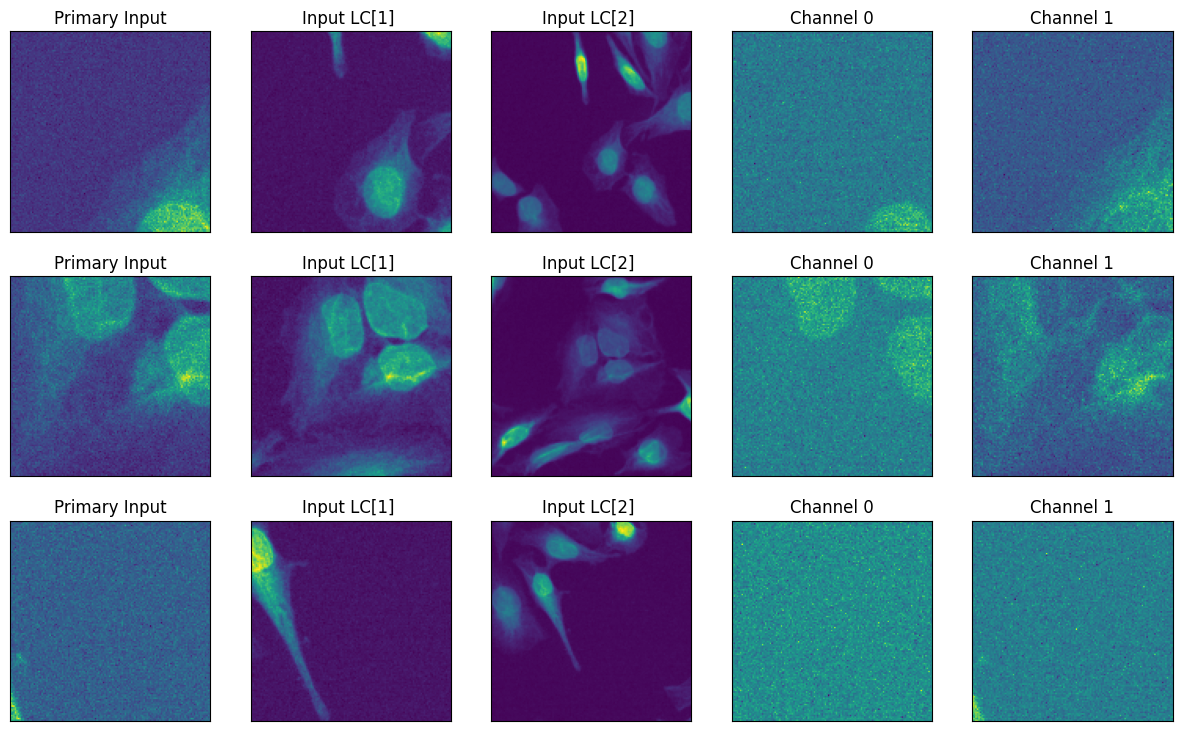

In [16]:
plot_input_patches(dataset=dset, num_channels=2, num_samples=3, patch_size=128)

### Create model and load checkpoint

In [17]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


In [18]:
from notebook_utils import load_pretrained_model
if evaluate_pretrained_model:
    ckpt_path = load_checkpoint_path(f"./pretrained_checkpoints/{EXPOSURE_DURATION}/", best=True)
    load_pretrained_model(model, ckpt_path)
else:
    assert evaluate_recently_trained_model == True, "Please select a model to evaluate"
    ckpt = load_checkpoint(f"./checkpoints/{EXPOSURE_DURATION}/", best=True)
    model.load_state_dict(ckpt["state_dict"], strict=True)

Loaded model from ./pretrained_checkpoints/5ms/best_0_1.ckpt


### Reduce the dataset size for faster evaluation
<div class="alert alert-block alert-info">
<b> Task: </b>If you set <b>reduce_data=True</b>, it will reduce the test dataset to have just 1 frame.

NOTE: If you wish to run 03_calibration.ipynb as well, you need to set <b>reduce_data=False</b>.
</div>



In [19]:
reduce_data = False

In [20]:
if reduce_data:
    dset.reduce_data([0])

[LCMultiChDloader] Data reduced. New data shape: (1, 1608, 1608, 3)


## Full frame evaluation

In [21]:
from notebook_utils import get_unnormalized_predictions, get_target, get_input
stitched_predictions, norm_stitched_predictions, stitched_stds = get_unnormalized_predictions(model, dset, EXPOSURE_DURATION, TARGET_CHANNEL_IDX_LIST, 
                                                    mmse_count =experiment_params['mmse_count'], 
                                                    num_workers=4, batch_size=8)
tar = get_target(dset)
inp = get_input(dset)

Predicting tiles: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s]


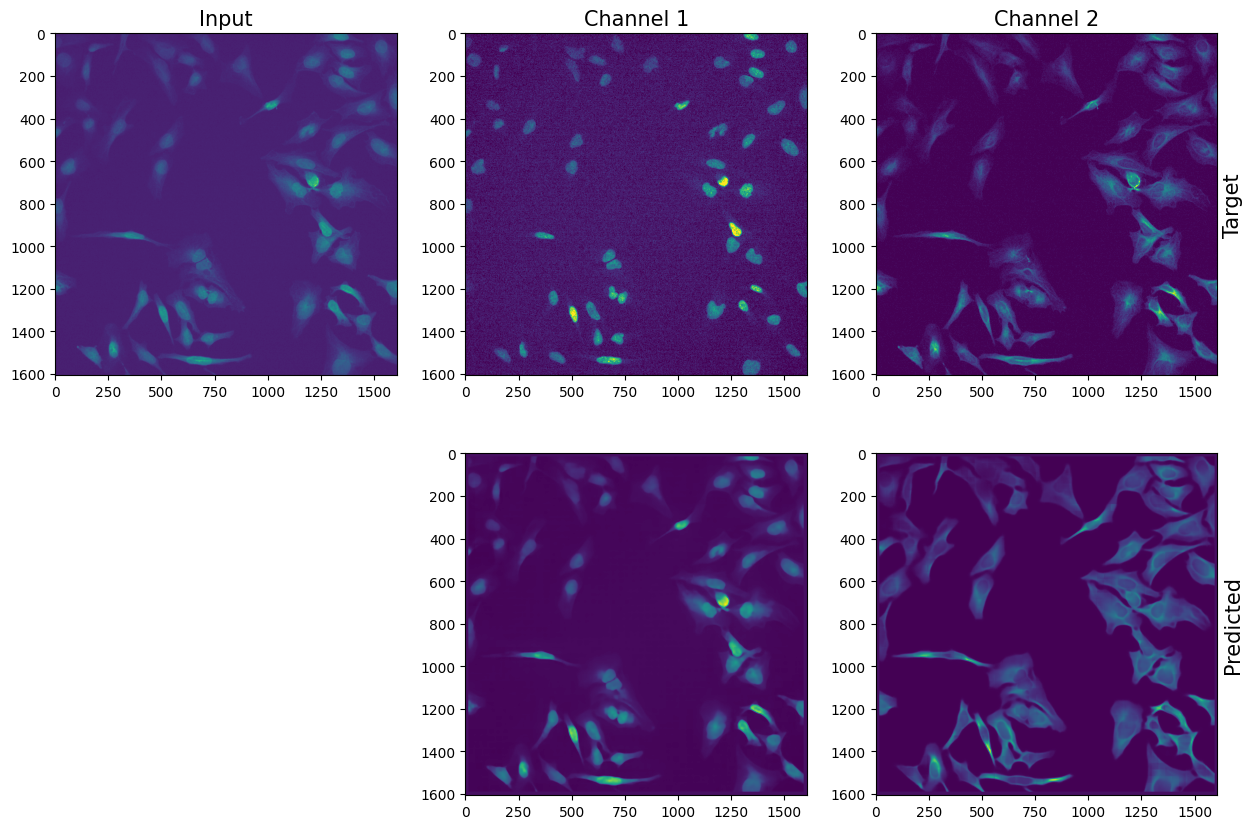

In [22]:
from notebook_utils import full_frame_evaluation
frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Few random locations
Here, we show few random foreground locations and the corresponding predictions from the dataset.

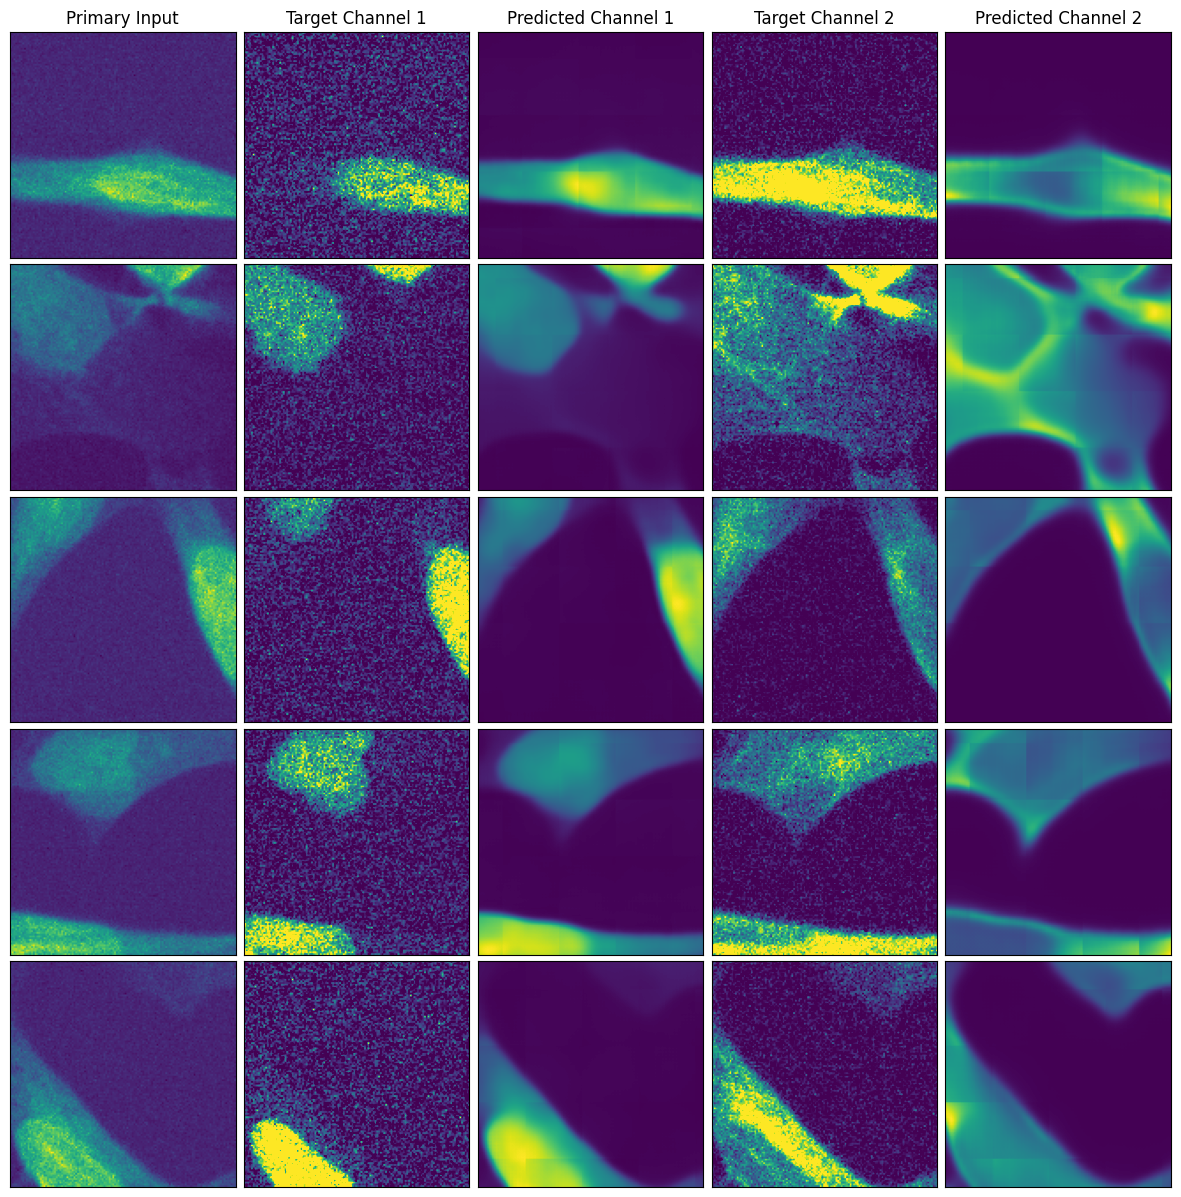

In [23]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from notebook_utils import pick_random_patches_with_content
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[2,0] #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[2,1] #np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 2*len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
    for j in range(ncols//2):
        vmin = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].min()
        vmax = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].max()
        ax[i,2*j+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)
        ax[i,2*j+2].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)

ax[0,0].set_title('Primary Input')
for i in range(len(TARGET_CHANNEL_IDX_LIST)):
    ax[0,2*i+1].set_title(f'Target Channel {i+1}')
    ax[0,2*i+2].set_title(f'Predicted Channel {i+1}')

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

### Inspecting different locations

Text(0, 0.5, 'Predicted')

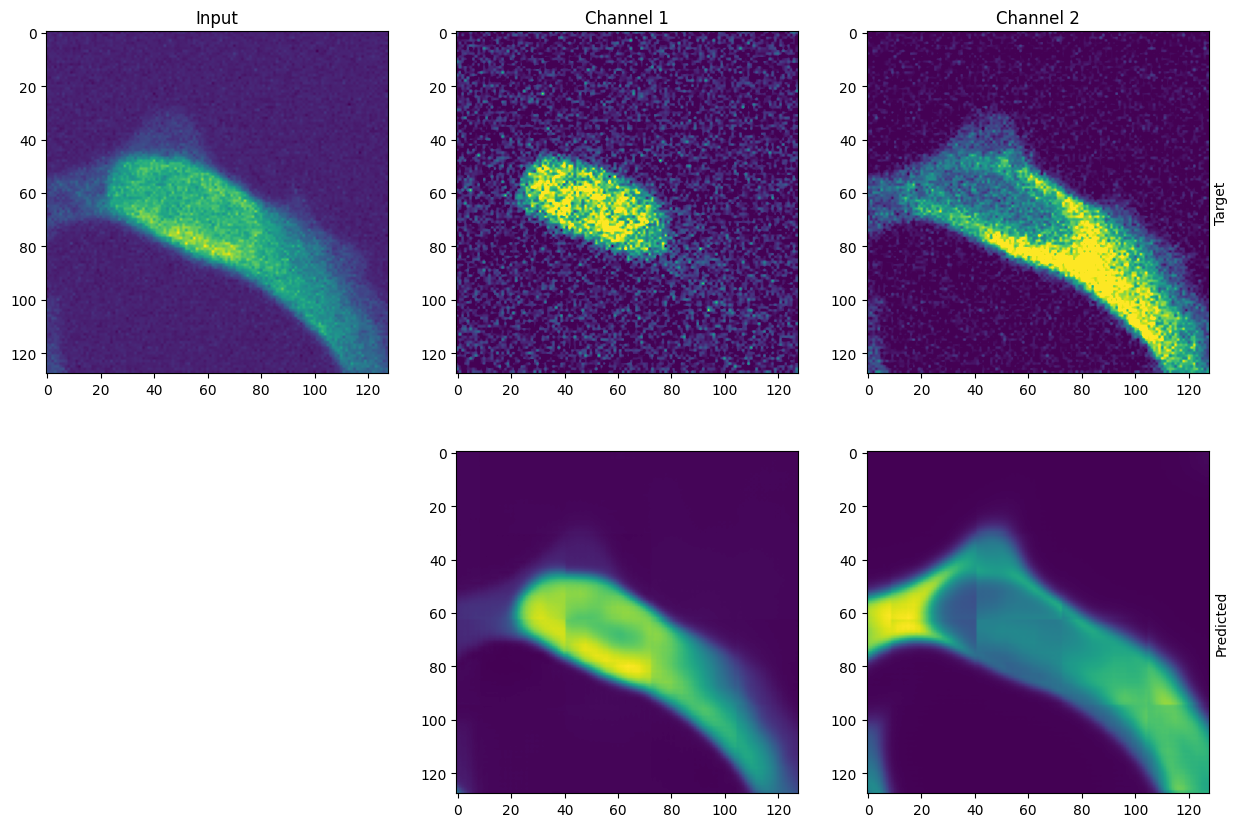

In [24]:
import numpy as np

img_sz = 128
h_start, w_start = rand_locations[-1]

ncols = len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
for i in range(ncols -1):
    vmin = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i].min()
    vmax = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i].max()
    ax[0,i+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i], vmin=vmin, vmax=vmax)
    ax[1,i+1].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i], vmin=vmin, vmax=vmax)

# disable the axis for ax[1,0]
ax[1,0].axis('off')
ax[0,0].set_title("Input")
ax[0,1].set_title("Channel 1")
ax[0,2].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0,2].yaxis.set_label_position("right")
ax[0,2].set_ylabel("Target")

ax[1,2].yaxis.set_label_position("right")
ax[1,2].set_ylabel("Predicted")

## Sampling
Here, we show multiple predictions for a single input patch.

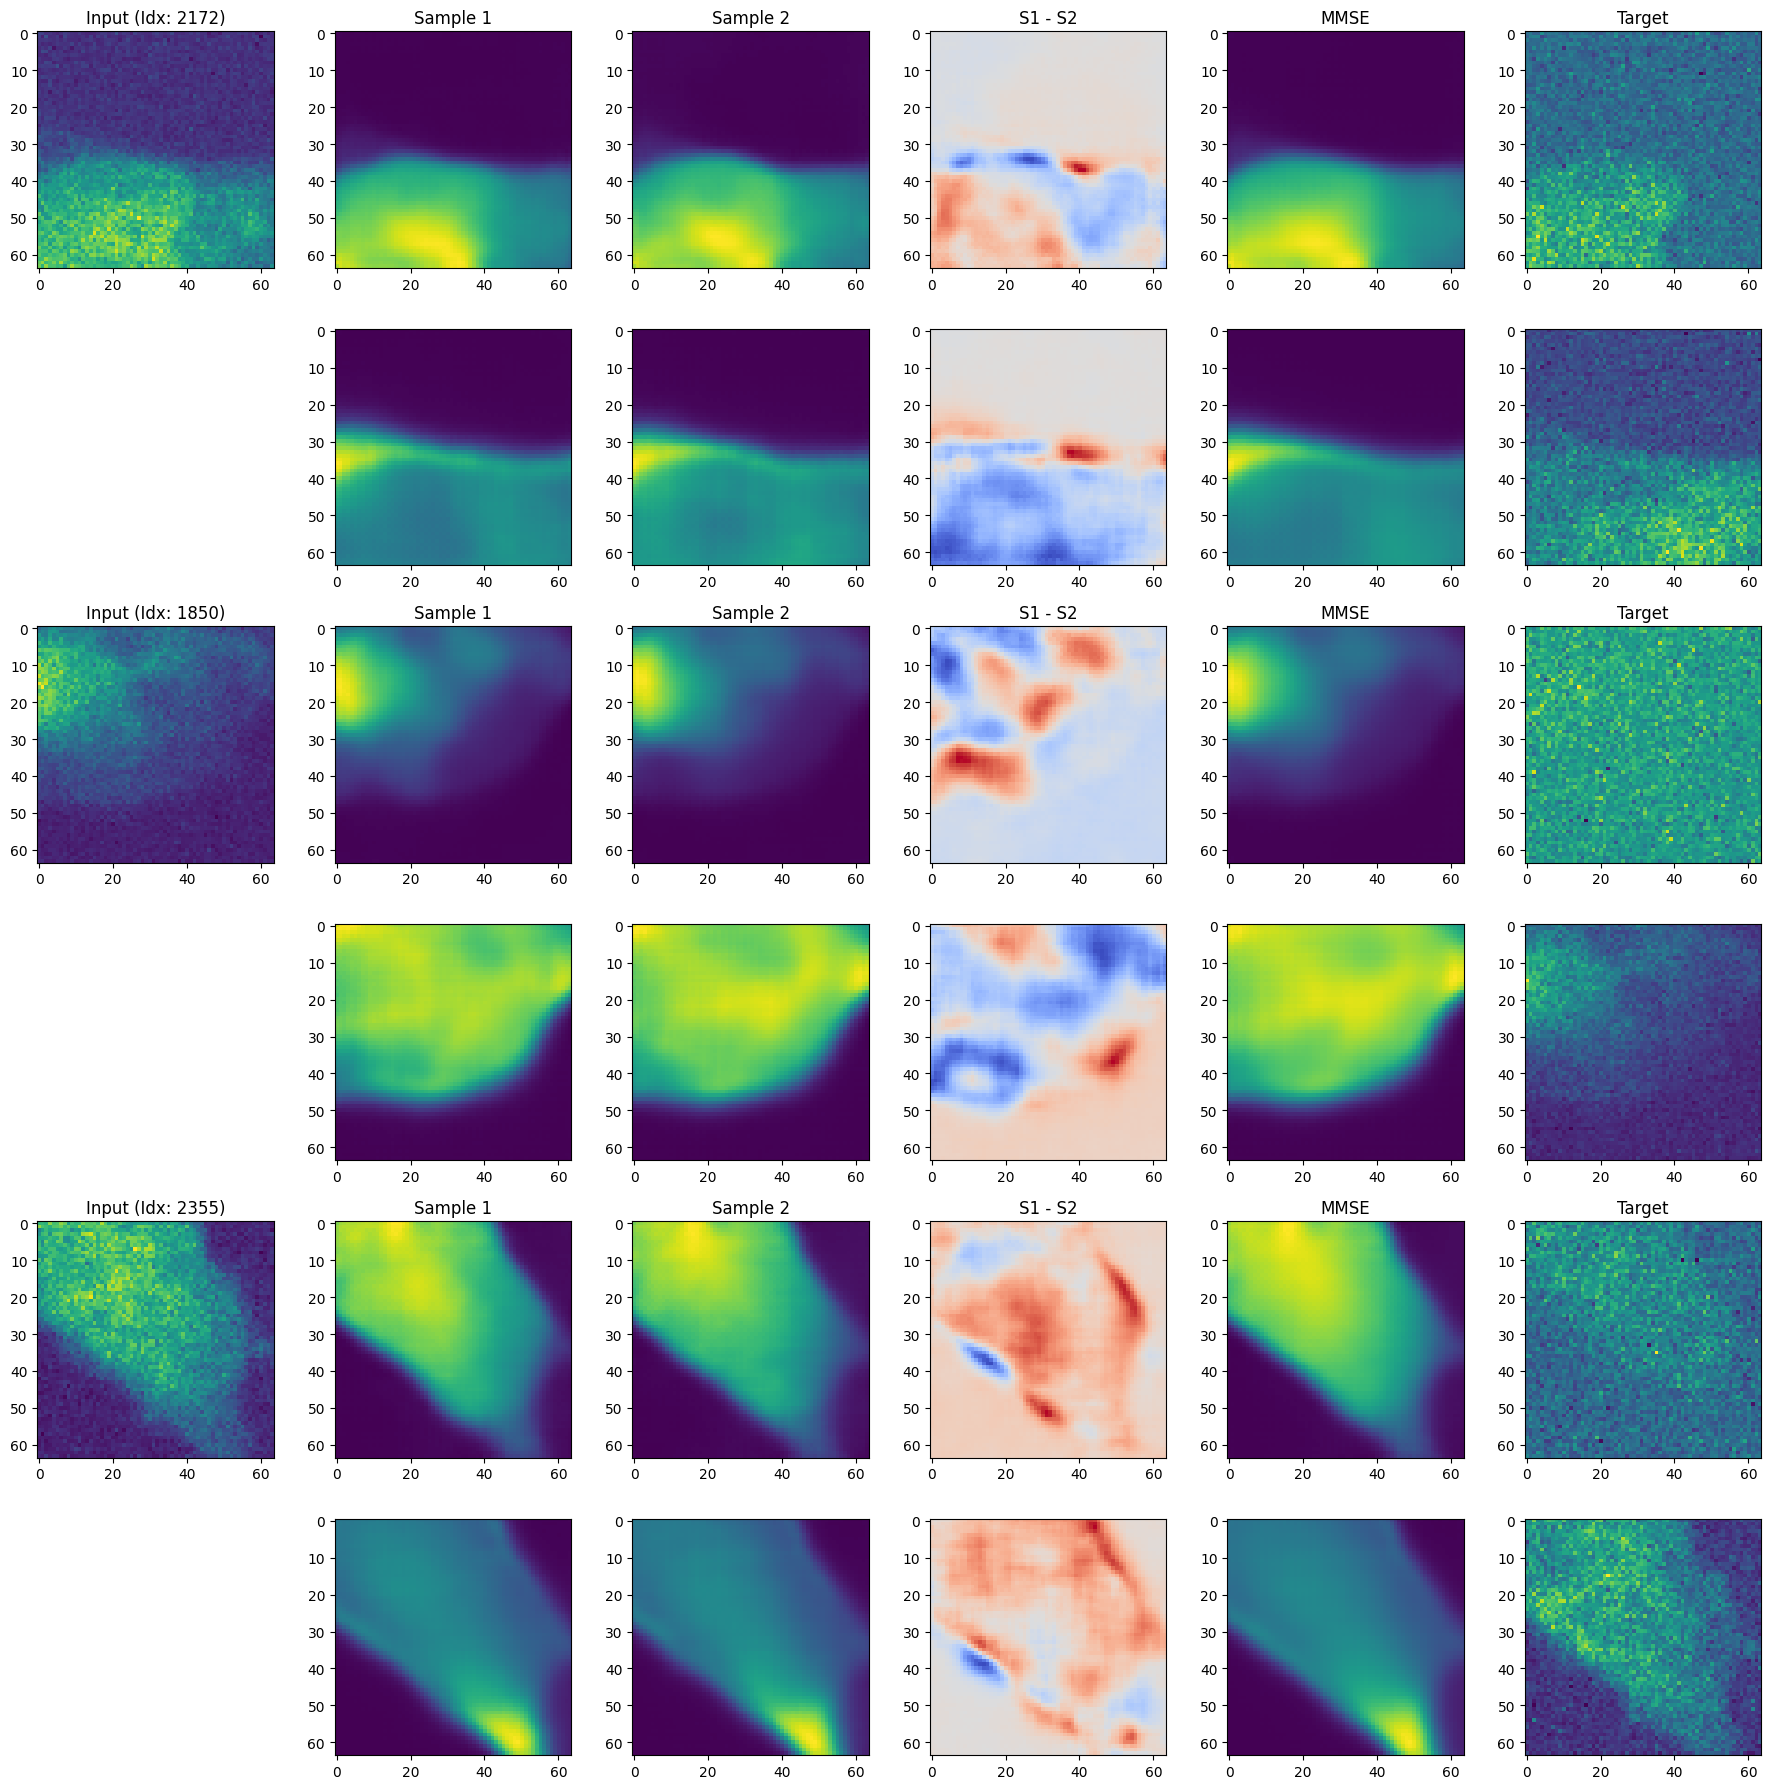

In [25]:
from notebook_utils import show_sampling
imgsz = 3
ncols = 6
examplecount = 3
_,ax = plt.subplots(figsize=(imgsz*ncols, imgsz*2*examplecount), ncols=ncols, nrows=2*examplecount)

show_sampling(dset, model, ax=ax[:2])
show_sampling(dset, model, ax=ax[2:4])
show_sampling(dset, model, ax=ax[4:6])
plt.tight_layout()

## Quantitative Evaluation
For HT-LIF24 dataset, we have the corresponding high-SNR groundtruth images. For computing the metrics, we will therefore use the high-SNR groundtruth images for target.

In [26]:
from notebook_utils import get_highsnr_data
highSNR_test_dset = get_highsnr_data(train_data_config, val_data_config, test_data_config, evaluate_on_validation)

Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set1/uSplit_500ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False


Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set2/uSplit_500ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set3/uSplit_500ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set4/uSplit_500ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set5/uSplit_500ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set6/uSplit_500ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False

Padding is not used with this alignement style
Loading from data/ht_lif24_500ms.zip.unzip/500ms/Set1/uSplit_500ms.nd2
ND2 dimensions: 

In [27]:
if reduce_data:
    highSNR_test_dset.reduce_data([0])

[LCMultiChDloader] Data reduced. New data shape: (1, 1608, 1608, 3)


In [28]:
target = highSNR_test_dset._data[..., :-1]

In [29]:
from microsplit_reproducibility.utils.paper_metrics import compute_high_snr_stats
_ = compute_high_snr_stats(target, stitched_predictions)

PSNR on Highres 27.09+-0.0	25.99+-0.0
MicroSSIM on Highres 
MicroS3IM on Highres 
SSIM on Highres 0.629+-0.000	0.680+-0.000
MSSSIM on Highres 0.810+-0.000	0.726+-0.000


## Saving the predictions for 03_calibration.ipynb

In [30]:
preddir = f"predictions/{EXPOSURE_DURATION}/"
os.makedirs(preddir, exist_ok=True)
# get the filename without the path and extension
filename = 'ht_lif24_' + ('Val' if evaluate_on_validation else 'Test')
tifffile.imwrite(
    f"{preddir}/prediction_{filename}.tif", norm_stitched_predictions
)
tifffile.imwrite(f"{preddir}/std_{filename}.tif", stitched_stds)
filename

'ht_lif24_Test'